# Modelling

In [1]:
#!pip install keras-tuner -q

In [1]:
# Importing packages
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import shutil
import cv2;

2023-08-11 13:55:27.180123: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from keras import models, layers, regularizers
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator;

from keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input, MaxPooling2D, Flatten
from keras_tuner import RandomSearch, GridSearch 
from keras.utils import set_random_seed

In [4]:
import matplotlib.pyplot as plt

In [5]:
from sklearn.dummy import DummyClassifier

In [6]:
import kerastuner.tuners as kt

/var/folders/mh/9l7f5q2x0bsc05929xvm2nnh0000gn/T/ipykernel_11232/982218236.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner.tuners as kt


In [313]:
import random
import os
from pretty_confusion_matrix import pp_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [8]:
import pickle

In [109]:
from sklearn.preprocessing import StandardScaler

In [252]:
from yellowbrick.classifier import ROCAUC

# 1.0 Importing data

In [9]:
gen_path = '/Users/chinmayasukumar/Documents/Capstone Projects/Capstone-3_Classifying_steel_defects/'

In [10]:
interim_path = gen_path + 'data/interim/'

In [11]:
# Loading images from preprocessing stage
images = np.load(interim_path + 'images.npy')

In [12]:
# Loading Dataframe 
df = pd.read_csv(interim_path + 'data.csv')

In [13]:
# One Hot Encoding labels
df = pd.get_dummies(df, columns=['Type'])

In [14]:
df.head()

,Filename,Number,Type_Crazing,Type_Inclusions,Type_Patches,Type_Pitted,Type_Rolled,Type_Scratches
0,Cr_1.bmp,1,1,0,0,0,0,0
1,Cr_10.bmp,10,1,0,0,0,0,0
2,Cr_100.bmp,100,1,0,0,0,0,0
3,Cr_101.bmp,101,1,0,0,0,0,0
4,Cr_102.bmp,102,1,0,0,0,0,0


In [15]:
# Creating labels, converting to array
labels = df.iloc[:,2:].to_numpy()

In [16]:
# Confirming shape of labels
labels.shape

(1800, 6)

In [18]:
labels

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]], dtype=uint8)

In [19]:
# Confirming shape of images
images.shape

(1800, 200, 200)

In [20]:
images.mean()

0.5031324834422657

In [21]:
images.std()

0.21237775109586898

In [22]:
# Sets seed for python, numpy and tensorflow 
random.seed(132)
np.random.seed(132)

# Checking seed
np.random.get_state()[1][0]

132

 # 2.1 Splitting Data

In [23]:
# Reshape images to (1800, 200, 200, 1) to account for black/white channel
images = images.reshape(-1,200,200,1)

In [24]:
# Splitting into train and (test, valid) sets, to be split further
X_train, X_test_val, y_train, y_test_val = train_test_split(images, labels, test_size=0.3)

# Splitting (test, valid) set into seperate test and validation sets
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

In [25]:
# Checking shapes
(X_train.shape, X_test.shape, X_val.shape)

((1260, 200, 200, 1), (270, 200, 200, 1), (270, 200, 200, 1))

In [26]:
# Checking shapes
(y_train.shape, y_test.shape, y_val.shape)

((1260, 6), (270, 6), (270, 6))

In [27]:
data = {'X_train':X_train, 'y_train':y_train, 'X_val':X_val, 'y_val':y_val, 'X_test':X_test, 'y_test':y_test}

with open(gen_path + 'data/interim/train_test_val.pkl', 'wb') as f:
        pickle.dump(data, f)

#### There are 1800 200x200 images each with a defect corresponding to one of 6 types

# 3.0 Model selection

# 3.1 Dummy Classifier

#### Evaluating dummy classifier to set benchmark for evaluating real models

In [41]:
# Insantiating a Dummy Classifier
dummy = DummyClassifier()

In [42]:
# Fitting to training set
dummy.fit(X_train, y_train)

DummyClassifier()

In [43]:
# Getting predictions
y_pred = dummy.predict(X_val)

In [44]:
# Converting from one-hot encoded
y_val_classes = np.argmax(y_val, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

In [45]:
print(classification_report(y_val_classes, y_pred_classes, zero_division=False))

              precision    recall  f1-score   support

           0       0.14      1.00      0.25        39
           1       0.00      0.00      0.00        48
           2       0.00      0.00      0.00        41
           3       0.00      0.00      0.00        53
           4       0.00      0.00      0.00        50
           5       0.00      0.00      0.00        39

    accuracy                           0.14       270
   macro avg       0.02      0.17      0.04       270
weighted avg       0.02      0.14      0.04       270



# 3.2 ResNet

In [29]:
# Fits model to training data (input) and validates on valuation data
# Restores best weights

model_path =  gen_path + 'models/'

def train_model(model, X_train, y_train, X_val, y_val, checkpoint_path, epochs, to_compile=False):
    
    # If model needs compiling
    if to_compile:
        model.compile(optimizer=Adam(),\
                      loss='categorical_crossentropy',\
                      metrics=['accuracy'])
    
    # Checkpoint to lowest val_loss
    # Saves weights of best model only
    # Saves to users specified checkpoint
    checkpoint = ModelCheckpoint(model_path + checkpoint_path,\
                                 monitor='val_loss', 
                                 save_best_model=True, \
                                 save_weights_only=True)
     
    # Returns history
    # Uses checkpoint as Callback
    history = model.fit(X_train, y_train,\
                        epochs=epochs, \
                        validation_data=(X_val, y_val),\
                        callbacks=[checkpoint])
        
    return history

## Transforming Grayscale to mimic RGB

In [39]:
# Simulating images so they appear RGB
# np.repeat repeats X_train's last column which is the column added for grayscale
X_train_rgb = np.repeat(X_train,3,-1)
X_test_rgb = np.repeat(X_test,3,-1)
X_val_rgb = np.repeat(X_val,3,-1)

In [48]:
X_train_rgb.shape, X_test_rgb.shape, X_val_rgb.shape

((1260, 200, 200, 3), (270, 200, 200, 3), (270, 200, 200, 3))

In [41]:
y_train.shape, y_test.shape, y_val.shape

((1260, 6), (270, 6), (270, 6))

In [42]:
labels[1500]

array([0, 0, 0, 0, 0, 1], dtype=uint8)

## Training ResNet

In [109]:
# Creating ResNet model
# input_tensor has shape (200, 200, 3) since ResNet only takes RGB images
# include_top = False since only 6 classes not 1000 in include_top ImageNet final layer
res_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(200,200,3)))

# Keeping original weights of ResNet the same
for layer in res_model.layers:
    layer.trainable = False

In [112]:
# Since most defects in images have large values, MaxPooling will be used
# Reduces dimensionality
x = GlobalAveragePooling2D()(res_model.output)

# Dense Layer 
x = Dense(512, activation='relu')(x)

# Multiclass classification so using softmax
output = Dense(6, activation='softmax')(x)

# Final model
final_res_model = Model(inputs=res_model.input, outputs=output)

final_res_model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 50, 50, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 50, 50, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 50, 50, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 50, 50, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 25, 25, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 25, 25, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 25, 25, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 25, 25, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 13, 13, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 13, 13, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 13, 13, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 13, 13, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 13, 13, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 13, 13, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 13, 13, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 13, 13, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [113]:
# Compiling, training and evaluating model
final_res_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

final_res_model_hist = train_model(final_res_model, X_train_rgb, y_train, X_val_rgb, y_val, 'resnet/resnet_checkpoint.h5', 10)

Epoch 1/10
40/40 [==============================] - 171s 4s/step - loss: 1.8981 - accuracy: 0.1738 - val_loss: 1.8091 - val_accuracy: 0.3000
Epoch 2/10
40/40 [==============================] - 172s 4s/step - loss: 1.7503 - accuracy: 0.2587 - val_loss: 1.6927 - val_accuracy: 0.3185
Epoch 3/10
40/40 [==============================] - 175s 4s/step - loss: 1.6951 - accuracy: 0.2794 - val_loss: 1.7357 - val_accuracy: 0.2481
Epoch 4/10
40/40 [==============================] - 144s 4s/step - loss: 1.6446 - accuracy: 0.3048 - val_loss: 1.6601 - val_accuracy: 0.2370
Epoch 5/10
40/40 [==============================] - 157s 4s/step - loss: 1.5856 - accuracy: 0.3286 - val_loss: 1.5312 - val_accuracy: 0.4148
Epoch 6/10
40/40 [==============================] - 164s 4s/step - loss: 1.5683 - accuracy: 0.3563 - val_loss: 1.6624 - val_accuracy: 0.2370
Epoch 7/10
40/40 [==============================] - 151s 4s/step - loss: 1.4995 - accuracy: 0.3563 - val_loss: 1.4469 - val_accuracy: 0.4000
Epoch 8/10
40

## Experimenting with Flatten()

In [114]:
# Since most defects in images have large values, MaxPooling will be used
# Reduces dimensionality
x = Flatten()(res_model.output)

# Dense Layer 
x = Dense(512, activation='relu')(x)

# Multiclass classification so using softmax
output = Dense(6, activation='softmax')(x)

# Final model
final_res_model = Model(inputs=res_model.input, outputs=output)

final_res_model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 50, 50, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 50, 50, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 50, 50, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 50, 50, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 25, 25, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 25, 25, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 25, 25, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 25, 25, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 13, 13, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 13, 13, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 13, 13, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 13, 13, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 13, 13, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 13, 13, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 13, 13, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 13, 13, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [115]:
# Compiling, training and evaluating model
final_res_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

final_res_model_hist = train_model(final_res_model, X_train_rgb, y_train, X_val_rgb, y_val, 'resnet/resnet_checkpoint.h5', 10)

Epoch 1/10
40/40 [==============================] - 223s 5s/step - loss: 11.2106 - accuracy: 0.2238 - val_loss: 1.5722 - val_accuracy: 0.4185
Epoch 2/10
40/40 [==============================] - 201s 5s/step - loss: 1.4150 - accuracy: 0.4397 - val_loss: 1.5710 - val_accuracy: 0.4037
Epoch 3/10
40/40 [==============================] - 205s 5s/step - loss: 1.4553 - accuracy: 0.4270 - val_loss: 1.4502 - val_accuracy: 0.4704
Epoch 4/10
40/40 [==============================] - 200s 5s/step - loss: 1.3935 - accuracy: 0.4611 - val_loss: 1.0725 - val_accuracy: 0.5037
Epoch 5/10
40/40 [==============================] - 214s 5s/step - loss: 1.1823 - accuracy: 0.5476 - val_loss: 0.9388 - val_accuracy: 0.7481
Epoch 6/10
40/40 [==============================] - 206s 5s/step - loss: 1.0908 - accuracy: 0.5754 - val_loss: 1.1289 - val_accuracy: 0.5148
Epoch 7/10
40/40 [==============================] - 199s 5s/step - loss: 1.2249 - accuracy: 0.5500 - val_loss: 1.0149 - val_accuracy: 0.6481
Epoch 8/10
4

## Evaluating ResNet

In [36]:
res_model_path = model_path + 'resnet/final_resnet_model.h5'
final_res_model = models.load_model(res_model_path)

In [254]:
# Building a function to predict and evaluate on Test set
# Returns confusion matrix and classification report

def predictor(model, X, y, print_report=False):
    # Features
    labels_ = ['Crazing', 'Inclusions', 'Patches', 'Pitted', 'Rolled', 'Scratches']
    
    # predictions on X_test
    y_pred = model.predict(X)
    
    # Gets classes in 1D array for predictions
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Classes for val set 
    y_val_classes = np.argmax(y, axis=1)
    
    # If true, prints both reports
    if print_report:
        
        # Prints confusion matrix
        results = confusion_matrix(y_val_classes, y_pred_classes)
        disp = ConfusionMatrixDisplay(results, display_labels=labels_)
        fig, ax = plt.subplots(figsize=(8,8))
        disp.plot(xticks_rotation=45.0, cmap='Blues', ax=ax)
        print('\n')
        
        # Prints classification report
        print('                 Classification report')
        
        print('\n')
        # zero_division=0.0 to prevent error
        print(classification_report(y_val_classes, y_pred_classes, target_names=labels_, zero_division=0.0))
    
    # Returns classification report with output_dict
    return classification_report(y_val_classes, y_pred_classes, target_names=labels_, \
                                 output_dict=True, zero_division=0.0)

9/9 [==============================] - 25s 3s/step


                 Classification report


              precision    recall  f1-score   support

     Crazing       1.00      0.76      0.86        42
  Inclusions       0.78      1.00      0.88        56
     Patches       0.89      0.87      0.88        47
      Pitted       0.00      0.00      0.00        38
      Rolled       0.51      1.00      0.68        46
   Scratches       1.00      0.73      0.85        41

    accuracy                           0.76       270
   macro avg       0.70      0.73      0.69       270
weighted avg       0.71      0.76      0.71       270



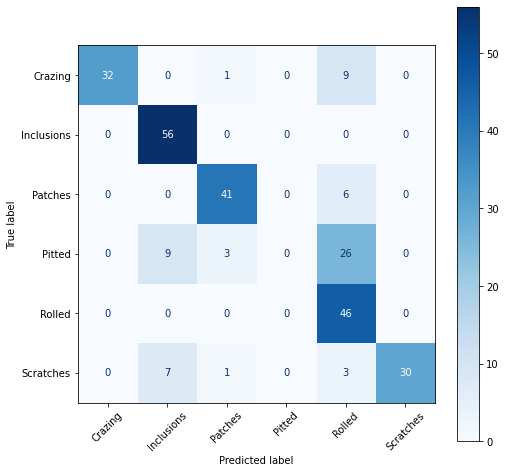

In [67]:
spredictor(final_res_model, X_val_rgb, y_val, print_report=True);

#### This model will be put on hold while CNN is tested

## Saving ResNet model and history

In [116]:
#final_res_model.save(model_path + '/resnet/final_resnet_model.h5')

In [119]:
#with open(model_path + 'resnet/resnet_hist.pkl', 'wb') as f:
#        pickle.dump(final_res_model_hist, f)

# 3.3 CNN

In [60]:
# Creates a CNN model and returns it
def create_model():    
    model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 1)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(6, activation='softmax')
            ])
    
    return model

In [61]:
# Instantiating base CNN model\
base_cnn = create_model();

In [62]:
base_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)       0

In [109]:
# Training model 
# Instantiating hist_base_cnn as the history returned from the train_model function
hist_base_cnn = train_model(base_cnn, X_train, y_train, X_val, y_val, \
                            'base_cnn/base_cnn_checkpoint.h5',\ 
                            epochs=10,\
                            to_compile=True)

In [40]:
# Function accepts trial history and title
# Returns model accuracy and loss in both train and validation sets
def grapher(history, title):
    
    # Two subplots for each ax
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Sets title
    fig.suptitle(title, fontsize=16)
    
    # Plots training and validation accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Plots training and validation loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

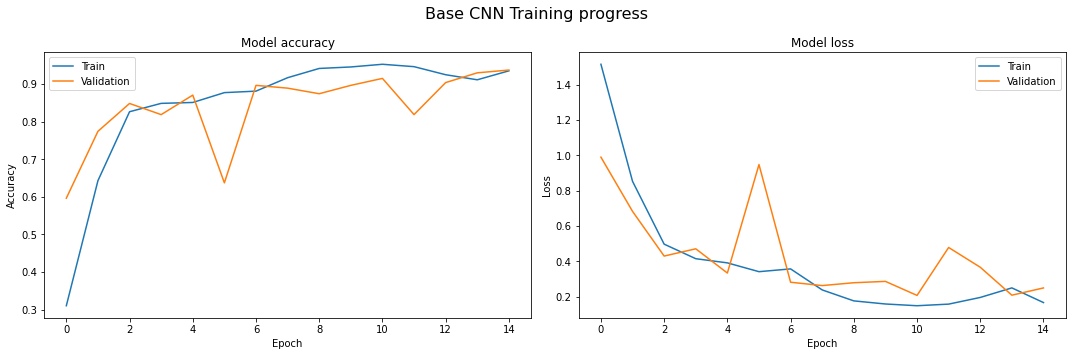

In [41]:
grapher(hist_base_cnn, 'Base CNN Training progress')

## Evaluating CNN

In [63]:
base_cnn.load_weights(model_path + 'base_cnn/base_cnn_checkpoint.h5')

9/9 [==============================] - 4s 411ms/step


                 Classification report


              precision    recall  f1-score   support

     Crazing       0.97      0.88      0.93        42
  Inclusions       0.92      1.00      0.96        56
     Patches       0.90      0.98      0.94        47
      Pitted       0.94      0.82      0.87        38
      Rolled       0.96      1.00      0.98        46
   Scratches       0.95      0.90      0.92        41

    accuracy                           0.94       270
   macro avg       0.94      0.93      0.93       270
weighted avg       0.94      0.94      0.94       270



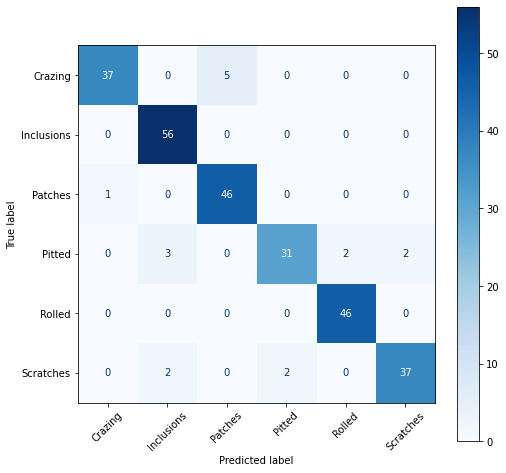

In [68]:
base_cnn_vals = predictor(base_cnn, X_val, y_val, True)

#### Inclusions, Patches, Pits and Scratches aren't classified properly

#### Classes Crazing, Pitted and Scratches don't have very good f1-scores

In [69]:
# Getting validation accuracy 
base_val_acc = predictor(base_cnn, X_val, y_val)['accuracy']
base_val_acc

9/9 [==============================] - 4s 419ms/step


0.937037037037037

In [70]:
# Getting training accuracy
base_acc = predictor(base_cnn, X_train, y_train)['accuracy']
base_acc

40/40 [==============================] - 15s 372ms/step


0.957936507936508

## Saving CNN

In [51]:
#base_cnn.save(model_path + 'base_cnn/final_base_cnn.h5')

# 4.0 Hyperparameter tuning

In [72]:
# Creating another CNN for hyperparameter tuning to feed into Tuner
# Learning rate will be chosen as hyperparameter

def create_model_1(hp):
    model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 1)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(6, activation='softmax'),
            ])

    # Learning rate can be changed
    learning_rate = hp.Float('learning_rate', 0.0001, 0.0151, sampling='log')
    
    # Compiling with learning rate fed into Adam optimizer
    model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy',\
        metrics=['accuracy'])

    return model

In [122]:
# Creating RandomSearch object 
# Creating directory to model path stated above

tuner_1 = RandomSearch(create_model_1, objective='val_accuracy', max_trials=12, executions_per_trial=1,
                       directory=model_path + 'tuner_dir/',
                       project_name='tuner_round_1',
                       overwrite=True); 

In [119]:
# Random Search value range
tuner_1.search_space_summary()

Search space summary
Default search space size: 1
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.0151, 'step': None, 'sampling': 'log'}


In [72]:
# Verifying shapes
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1260, 200, 200, 1), (1260, 6), (270, 200, 200, 1), (270, 6))

In [123]:
# EarlyStopping to get best weights
tuner_1_stop = EarlyStopping(monitor='val_loss',
                    # 3 epochs to improve val_loss
                    patience=3,
                    mode='min',
                    # Restoring best weights of each trial
                    restore_best_weights=True,\
                    start_from_epoch=2)

tuner_1_logs = CSVLogger(model_path + 'tuner_dir/tuner_round_1/tuner_1_logs.csv')

In [124]:
# Running Random Search
tuner_1.search(X_train, y_train, \
               epochs=11, \
               validation_data=(X_val, y_val), \
               callbacks=[tuner_1_stop, tuner_1_logs])

Trial 12 Complete [00h 07m 47s]
val_accuracy: 0.9296296238899231

Best val_accuracy So Far: 0.9444444179534912
Total elapsed time: 02h 02m 39s
INFO:tensorflow:Oracle triggered exit


In [126]:
tuner_1.results_summary()

Results summary
Results in /Users/chinmayasukumar/Documents/Capstone Projects/Capstone-3_Classifying_steel_defects/models/tuner_dir/tuner_round_1
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 08 summary
Hyperparameters:
learning_rate: 0.0016034905008069655
Score: 0.9444444179534912

Trial 00 summary
Hyperparameters:
learning_rate: 0.00037929467792676097
Score: 0.9333333373069763

Trial 02 summary
Hyperparameters:
learning_rate: 0.0005835409602249638
Score: 0.9296296238899231

Trial 04 summary
Hyperparameters:
learning_rate: 0.00044449476348729403
Score: 0.9296296238899231

Trial 06 summary
Hyperparameters:
learning_rate: 0.0005634185728375876
Score: 0.9296296238899231

Trial 11 summary
Hyperparameters:
learning_rate: 0.0006255194064093167
Score: 0.9296296238899231

Trial 03 summary
Hyperparameters:
learning_rate: 0.00014868211121270912
Score: 0.914814829826355

Trial 09 summary
Hyperparameters:
learning_rate: 0.0014137593904332256
Score: 0.84444445371627

In [99]:
# Reloading tuner values 
tuner_1_copy = RandomSearch(create_model_1, objective='val_accuracy', max_trials=12, executions_per_trial=1,
                       directory='/Users/chinmayasukumar/Documents/Capstone Projects/Capstone-3_Classifying_steel_defects/models/tuner_dir',
                       project_name='tuner_round_1_copy',
                       overwrite=False);

INFO:tensorflow:Reloading Tuner from /Users/chinmayasukumar/Documents/Capstone Projects/Capstone-3_Classifying_steel_defects/models/tuner_dir/tuner_round_1_copy/tuner0.json


## Comparing Results

In [165]:
def make_table(tuner, round_number):
    # Metrics to be evaluated
    metrics = ['accuracy', 'loss', 'val_accuracy', 'val_loss']
    
    # Instantiating empty lists
    trial_list  = list()
    lr = list()
    opt = ['adam' for i in range(12)]
    acc = list()
    loss = list()
    val_acc = list()
    val_loss = list()
    
    # List of metric lists from above
    metrics_list_ = [acc, loss, val_acc, val_loss]
    
    # Looping through all the trials
    for trial in tuner.oracle.get_best_trials(11):
        
        # Appending trial info to corresponding tables
        trial_list.append(trial.trial_id)
        
        # Appending learning rates
        lr.append(trial.hyperparameters.values['learning_rate'])
    
        # Appending individual metric to corresponding tables
        for m, metric in zip(metrics_list_, metrics):
            m.append(trial.metrics.get_history(metric)[0].value[0])
    
    # Combining list into DataFrame
    results = pd.DataFrame({'Trial Number':trial_list + [np.nan],
                            'Learning rate':lr + [0.001],
                            'Optimizer':opt,
                            'Accuracy':acc + [base_acc],
                            'Loss':loss + [np.nan],
                            'Val accuracy':val_acc + [base_val_acc],
                            'Val loss':val_loss + [np.nan]})
    
    return results

In [166]:
# Making table for trials
trials = make_table(tuner_1_copy, round_number=1)

In [173]:
trials.sort_values(by='Val accuracy', ascending=False)

,Trial Number,Learning rate,Optimizer,Accuracy,Loss,Val accuracy,Val loss
0,08,0.001603,adam,0.944444,0.173227,0.944444,0.223986
11,NaN,0.001000,adam,0.957937,NaN,0.937037,NaN
1,00,0.000379,adam,0.940476,0.173955,0.933333,0.193365
2,04,0.000444,adam,0.915079,0.258081,0.929630,0.230726
3,06,0.000563,adam,0.928571,0.201426,0.929630,0.251955
4,02,0.000584,adam,0.822222,0.449366,0.929630,0.290097
5,11,0.000626,adam,0.924603,0.219491,0.929630,0.252830
6,03,0.000149,adam,0.922222,0.233239,0.914815,0.260802
7,09,0.001414,adam,0.850794,0.429369,0.844444,0.407717
8,01,0.009118,adam,0.667460,0.803256,0.651852,0.885851


## Plotting Results

In [168]:
# Accepts trials in question
# Accepts deltaX and deltaY, positions for text box
def train_test_plotter(trials, deltaX, deltaY):
    plt.figure(figsize=(7,5), dpi=130)

    # Plotting learning rates vs. training and test accuracy
    plt.scatter(trials['Learning rate'], trials['Accuracy'], label='Training accuracy')
    plt.scatter(trials['Learning rate'], trials['Val accuracy'], label='Val accuracy')

    # Indexing observation with highest Test accuracy
    index = trials['Val accuracy'].idxmax()

    # Getting learning rate and test accuracy for highest test accuracy value
    x1, y1 = trials.iloc[index,:]['Learning rate'], trials.iloc[index,:]['Val accuracy']

    # Getting coordinates of highest test accuracy to be printed on graph
    note = str(x1.round(5)) + ', \n' + str(y1.round(5))

    # Creating dict of arguments for arrow and box
    arrow_dict = {'facecolor':'black', 'shrink':0.05, 'lw':0.05, 'width':0.5}
    bbox_dict = {'boxstyle':'round,pad=0.2', 'fc':'lightgray', 'ec':'black', 'lw':0.5}

    # Annotating arrow and note in box using arrow and box dictionariers
    plt.annotate(note, xy=(x1,y1), xytext=(x1+deltaX, y1-deltaY), arrowprops=arrow_dict,\
                bbox=bbox_dict)

    # Title and labels
    plt.title('Accuracies vs. learning rates')
    plt.xlabel('Learning rate')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

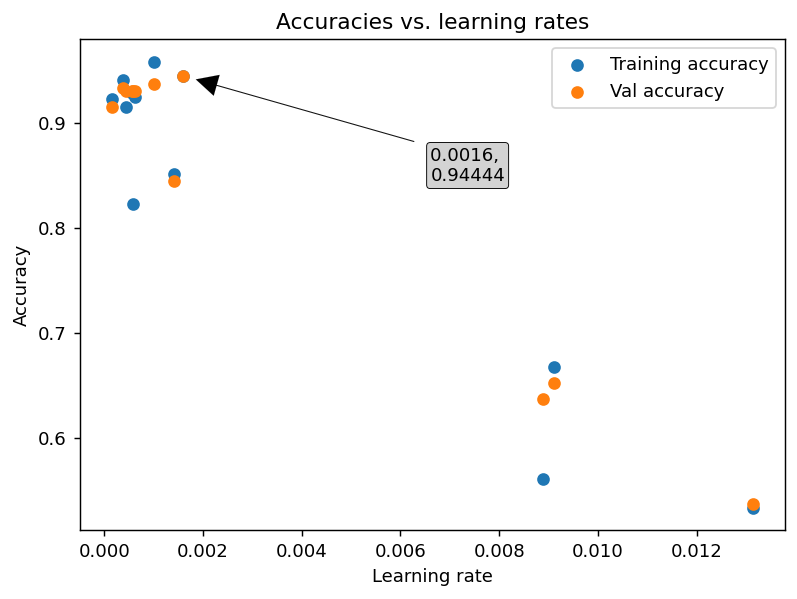

In [169]:
train_test_plotter(trials, deltaX=0.005, deltaY=0.1)

In [130]:
# Reloading best model from tuner
first = tuner_1_copy.get_best_models(1)[0]

In [151]:
# Confirming learning rate
first_hp = tuner_1_copy.get_best_hyperparameters(1)[0]
first_hp.values

{'learning_rate': 0.0016034905008069655}

9/9 [==============================] - 3s 265ms/step


                 Classification report


              precision    recall  f1-score   support

     Crazing       1.00      1.00      1.00        42
  Inclusions       1.00      0.91      0.95        56
     Patches       1.00      1.00      1.00        47
      Pitted       0.84      1.00      0.92        38
      Rolled       1.00      0.98      0.99        46
   Scratches       0.95      0.93      0.94        41

    accuracy                           0.97       270
   macro avg       0.97      0.97      0.97       270
weighted avg       0.97      0.97      0.97       270



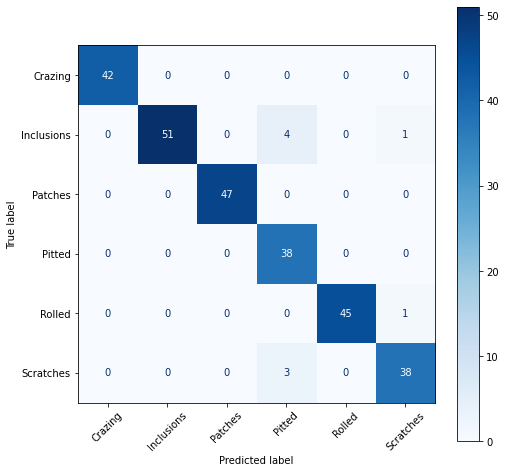

In [152]:
# Predicting on validation set
predictor(first, X_val, y_val, print_report=True);

# 5.0 Standard Score Normalizing

In [118]:
# X_train mean and st dev
X_train_mean = np.mean(X_train)
X_train_std = np.std(X_train)

In [119]:
# Function to standardize X sets using training mean and std dev
def standardize(X):
    return ((X - X_train_mean)/X_train_std)

In [120]:
X_train_adj, X_test_adj, X_val_adj = standardize(X_train), standardize(X_test), standardize(X_val)

In [402]:
# Confirming shapes
X_train_adj.shape, y_train_adj.shape

((1260, 200, 200, 1), (1260, 6))

In [403]:
# Confirming shapes
X_val_adj.shape, y_val_adj.shape

((270, 200, 200, 1), (270, 6))

In [413]:
# New normalized model 
norm_cnn = create_model()

In [414]:
# Training normalized CNN
history_norm_cnn = train_model(norm_cnn, X_train_adj, y_train, X_val_adj, y_val,\
                               'norm_cnn/norm_cnn_checkpoint.h5', epochs=12, to_compile=True)

Epoch 1/12
40/40 [==============================] - 55s 1s/step - loss: 1.2620 - accuracy: 0.4738 - val_loss: 0.9868 - val_accuracy: 0.6667
Epoch 2/12
40/40 [==============================] - 42s 1s/step - loss: 0.5966 - accuracy: 0.7690 - val_loss: 0.8733 - val_accuracy: 0.6852
Epoch 3/12
40/40 [==============================] - 40s 1s/step - loss: 0.3868 - accuracy: 0.8643 - val_loss: 0.2679 - val_accuracy: 0.8741
Epoch 4/12
40/40 [==============================] - 40s 992ms/step - loss: 0.2176 - accuracy: 0.9286 - val_loss: 0.1489 - val_accuracy: 0.9556
Epoch 5/12
40/40 [==============================] - 38s 962ms/step - loss: 0.3069 - accuracy: 0.9024 - val_loss: 0.3104 - val_accuracy: 0.8926
Epoch 6/12
40/40 [==============================] - 40s 997ms/step - loss: 0.1518 - accuracy: 0.9532 - val_loss: 0.4713 - val_accuracy: 0.8519
Epoch 7/12
40/40 [==============================] - 40s 998ms/step - loss: 0.2121 - accuracy: 0.9230 - val_loss: 0.1861 - val_accuracy: 0.9444
Epoch 8/

In [177]:
X_adj_2 = standardize(X_train)

In [154]:
# Had to reload norm_cnn

In [122]:
# Creating model
norm_cnn = create_model()

In [124]:
# Loading weights
norm_cnn.load_weights('/Users/chinmayasukumar/Documents/Capstone Projects/Capstone-3_Classifying_steel_defects/models/norm_cnn/norm_cnn_checkpoint.h5')

9/9 [==============================] - 3s 332ms/step


                 Classification report


              precision    recall  f1-score   support

     Crazing       1.00      1.00      1.00        42
  Inclusions       1.00      0.98      0.99        56
     Patches       0.98      1.00      0.99        47
      Pitted       0.97      1.00      0.99        38
      Rolled       1.00      1.00      1.00        46
   Scratches       1.00      0.98      0.99        41

    accuracy                           0.99       270
   macro avg       0.99      0.99      0.99       270
weighted avg       0.99      0.99      0.99       270



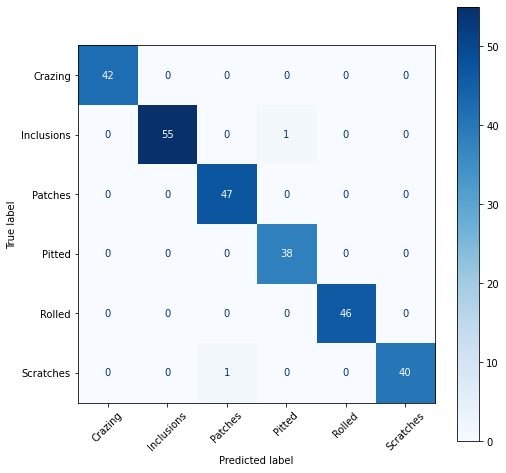

In [153]:
# Results for testing on validation set
predictor(norm_cnn, X_val_adj, y_val, print_report=True);

# 6.0 Evaluating CNN on test set

In [325]:
y_pred = norm_cnn.predict(X_test_adj)

9/9 [==============================] - 3s 275ms/step


In [331]:
plt.rcdefaults()



                 Classification report


              precision    recall  f1-score   support

     Crazing       1.00      1.00      1.00        39
     Patches       0.91      0.90      0.91        48
      Pitted       1.00      1.00      1.00        41
      Rolled       0.94      0.96      0.95        53
  Inclusions       1.00      1.00      1.00        50
   Scratches       0.95      0.95      0.95        39

    accuracy                           0.97       270
   macro avg       0.97      0.97      0.97       270
weighted avg       0.97      0.97      0.97       270



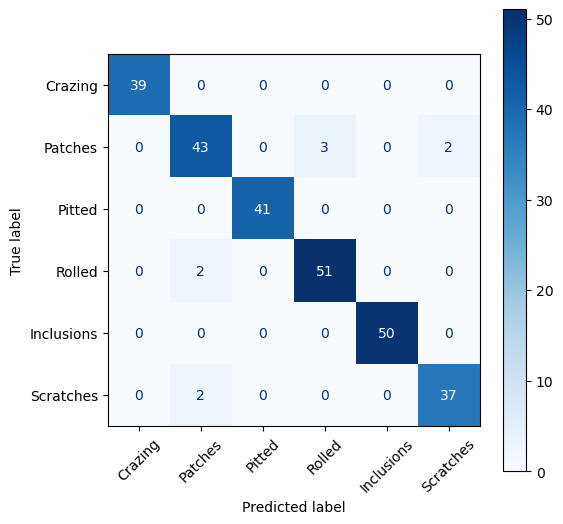

In [333]:
# Gets classes in 1D array for predictions
y_pred_classes = np.argmax(y_pred, axis=1)

# Classes for test set 
y_test_classes = np.argmax(y_test, axis=1)

results = confusion_matrix(y_test_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(results, display_labels=labels_)

fig_, ax_ = plt.subplots(figsize=(6,6))
disp.plot(xticks_rotation=45.0, cmap='Blues', ax=ax_)
print('\n')
        
# Prints classification report
print('                 Classification report')
        
print('\n')

# zero_division=0.0 to prevent error
print(classification_report(y_test_classes, y_pred_classes, target_names=labels_, zero_division=0.0))  

In [419]:
# Saving final model
# norm_cnn.save('/Users/chinmayasukumar/Documents/Springboard/Capstone 3 - Metal defect detection/models/norm_final_model.h5')